In [5]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Environment 1:Cartpole

In [ ]:
env=gym.make('CartPole-v1')


4

In [ ]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.dense1 = nn.Linear(len(env.observation_space.sample()), 128)
    self.relu=nn.ReLU()
    self.dense2 = nn.Linear(128, 256)
    self.dense3 = nn.Linear(256, env.action_space.n)
    self.softmax= nn.Softmax(-1)

  def forward(self,x):
    x=self.dense1(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.dense3(x)
    x=self.softmax(x)
    # print(x)
    x=Categorical(x)
    return x


class Critic(nn.Module):
    def __init__(self,):
      super(Critic, self).__init__()
      self.dense1 = nn.Linear(len(env.observation_space.sample())+env.action_space.n, 128)
      self.relu=nn.ReLU()
      self.dense2 = nn.Linear(128, 256)
      self.dense3 = nn.Linear(256, 1)

    def forward(self, x):
      x=self.dense1(x)
      x=self.relu(x)
      x=self.dense2(x)
      x=self.relu(x)
      x=self.dense3(x)
      return x

def get_OneHot_Actions(actions,number_of_actions):
  t=torch.zeros(number_of_actions)
  t[action]=1
  # print(t)
  return t



actor=Actor().to(device)
critic=Critic().to(device)
number_of_episodes=2000
Actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
Critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
gamma=0.99
rew_per_episode=[]
avg_rewards_per_episodes=[]
for episode in range(1, number_of_episodes+1):
  current_state= env.reset()
  state= torch.FloatTensor(current_state).to(device)
  done=False
  cum_rew=0
  log_prob_list = []
  value_list = []
  reward_list = []
  done_list = []
  returns=[]
  entropy = 0
  while done==False:
    actions=actor(state)
    action=actions.sample()
    encoded_actions=get_OneHot_Actions(action, env.action_space.n)
    value=critic(torch.cat((state,encoded_actions)))
    # print(actions,value)
    # print(action)
    log_prob=actions.log_prob(action).unsqueeze(0)
    # print(log_prob)
    # print(action,value)
    next_state, reward, done, _ = env.step(np.asarray(action))
    cum_rew+=reward
    next_state=torch.Tensor(next_state).to(device)    
    reward=torch.Tensor([reward]).to(device)
    if done:
      done_list.append(torch.Tensor([0]).to(device))
    else:
      done_list.append(torch.Tensor([1]).to(device)) 
    # log_prob=torch.tensor([log_prob]).to(device)
    log_prob_list.append(log_prob)
    value_list.append(value)
    reward_list.append(reward)
    state=next_state
  value_list=torch.cat(value_list).to(device)
  # print(log_prob_list)
  log_prob_list=torch.cat(log_prob_list).to(device)
  # print(value_list)
  R=critic(torch.cat((state,encoded_actions)))
  # print(log_prob_list)
  # print(R)
  # print(reward_list)
  returns=[]
  for i in range(len(reward_list)-1, -1,-1):
    # print(done_list[i], reward_list[i])
    R=reward_list[i]+gamma*R*done_list[i]
    returns.insert(0,R)
  # print(returns)
  returns=torch.cat(returns).to(device)
  # print(returns)
  advantage=returns-value_list
  # print("A",advantage)
  # print("L",log_prob_list)
  td_error=(-log_prob_list*advantage).mean()
  value_error=advantage.mean()
  # print("saKXML",value_error)
  # print("AL:",td_error)
  # print("CL:", value_error)
  Actor_optimizer.zero_grad()
  Critic_optimizer.zero_grad()
  (td_error).backward(retain_graph=True)
  Actor_optimizer.step()
  value_error.backward()
  Critic_optimizer.step()
    # print(log_prob)
    # print(done_list)
    # break
  rew_per_episode.append(cum_rew)
  # print('--------Episode:',episode,'--------Reward:',cum_rew)

  if len(rew_per_episode)>20:
    s=sum(rew_per_episode[len(rew_per_episode)-20:len(rew_per_episode)])/20
    print('--------Episode:',episode,'--------Reward:',cum_rew,'-------Avg Rewards(last 20 episodes):', int(s))
    avg_rewards_per_episodes.append(s)
    if s>470:
      print("Converged!")
      break
  else:
    # print(len(avg_rewards_per_episodes))
    avg_rewards_per_episodes.append(int(sum(avg_rewards_per_episodes)/(len(avg_rewards_per_episodes)+1)))


--------Episode: 21 --------Reward: 15.0 -------Avg Rewards(last 20 episodes): 20
--------Episode: 22 --------Reward: 17.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 23 --------Reward: 22.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 24 --------Reward: 24.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 25 --------Reward: 13.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 26 --------Reward: 15.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 27 --------Reward: 18.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 28 --------Reward: 25.0 -------Avg Rewards(last 20 episodes): 21
--------Episode: 29 --------Reward: 15.0 -------Avg Rewards(last 20 episodes): 22
--------Episode: 30 --------Reward: 20.0 -------Avg Rewards(last 20 episodes): 20
--------Episode: 31 --------Reward: 20.0 -------Avg Rewards(last 20 episodes): 20
--------Episode: 32 --------Reward: 20.0 -------Avg Rewards(last 20 episodes): 20
--------Episode:

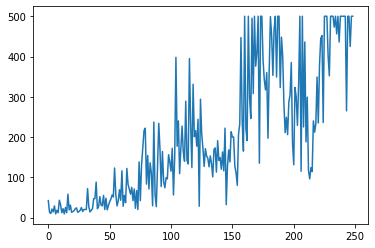

In [ ]:
plt.plot(rew_per_episode)

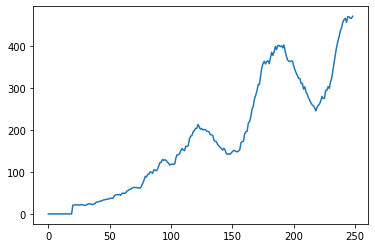

In [ ]:
plt.plot(avg_rewards_per_episodes)

###Environment 2: LUNAR LANDER

In [3]:
!pip3 install box2d-py
!pip install gym[box2d]

     |████████████████████████████████| 448 kB 12.7 MB/s 


In [3]:
env = gym.make("LunarLander-v2")
env.observation_space.sample()

array([ 0.56525165, -0.16598831, -0.18851788,  0.5093149 , -0.35105222,
        0.91421294, -0.22964478, -0.21865802], dtype=float32)

In [ ]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.dense1 = nn.Linear(len(env.observation_space.sample()), 128)
    self.relu=nn.ReLU()
    self.dense2 = nn.Linear(128, 256)
    self.dense3 = nn.Linear(256, env.action_space.n)
    self.softmax= nn.Softmax(-1)

  def forward(self,x):
    x=self.dense1(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.dense3(x)
    x=self.softmax(x)
    # print(x)
    x=Categorical(x)
    return x


class Critic(nn.Module):
    def __init__(self,):
      super(Critic, self).__init__()
      self.dense1 = nn.Linear(len(env.observation_space.sample()), 128)
      self.relu=nn.ReLU()
      self.dense2 = nn.Linear(128, 256)
      self.dense3 = nn.Linear(256, 1)

    def forward(self, x):
      x=self.dense1(x)
      x=self.relu(x)
      x=self.dense2(x)
      x=self.relu(x)
      x=self.dense3(x)
      return x

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


actor=Actor()
critic=Critic()
number_of_episodes=1500
Actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
Critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
gamma=0.99
rew_per_episode=[]

for episode in range(1, number_of_episodes+1):
  current_state= env.reset()
  state= torch.FloatTensor(current_state)
  done=False
  cum_rew=0
  log_prob_list = []
  value_list = []
  reward_list = []
  done_list = []
  returns=[]
  entropy = 0

  while done==False:
    state= torch.FloatTensor(state)
    dist, value = actor(state), critic(state)
    action = dist.sample()
    next_state, reward, done, _ = env.step(action.numpy())

    log_prob = dist.log_prob(action).unsqueeze(0)
    entropy += dist.entropy().mean()

    log_prob_list.append(log_prob)
    value_list.append(value)
    cum_rew+=reward
    reward_list.append(torch.tensor([reward], dtype=torch.float))
    done_list.append(torch.tensor([1-done], dtype=torch.float))
    state = next_state


  next_state = torch.FloatTensor(next_state)
  R = critic(next_state)
  returns=[]
  for i in range(len(reward_list)-1, -1,-1):
    R=reward_list[i]+gamma*R*done_list[i]
    returns.insert(0,R)

  rew_per_episode.append(cum_rew)
  log_prob_list = torch.cat(log_prob_list)
  returns = torch.cat(returns).detach()
  #print(returns)
  value_list = torch.cat(value_list)

  advantage = returns - value_list

  actor_loss = -(log_prob_list * advantage.detach()).mean()
  critic_loss = advantage.pow(2).mean()
  Actor_optimizer.zero_grad()
  Critic_optimizer.zero_grad()
  actor_loss.backward(retain_graph=True)
  critic_loss.backward()
  Actor_optimizer.step()
  Critic_optimizer.step()
  print('--------Episode:',episode,'--------Reward:',cum_rew)


--------Episode: 1 --------Reward: -168.15065022239514
--------Episode: 2 --------Reward: -377.7772311691566
--------Episode: 3 --------Reward: -298.87056156509493
--------Episode: 4 --------Reward: -242.88921703808012
--------Episode: 5 --------Reward: -125.94630411918786
--------Episode: 6 --------Reward: -157.9451201740361
--------Episode: 7 --------Reward: -224.95853639317755
--------Episode: 8 --------Reward: -403.1211683555961
--------Episode: 9 --------Reward: -118.34022452855086
--------Episode: 10 --------Reward: -455.55433584699006
--------Episode: 11 --------Reward: -127.84048929331513
--------Episode: 12 --------Reward: -132.22219899527505
--------Episode: 13 --------Reward: -168.90090674285372
--------Episode: 14 --------Reward: -117.3725692017738
--------Episode: 15 --------Reward: -320.7746614781538
--------Episode: 16 --------Reward: -131.01299799521425
--------Episode: 17 --------Reward: -95.24852059874569
--------Episode: 18 --------Reward: -140.92500014721946
-------

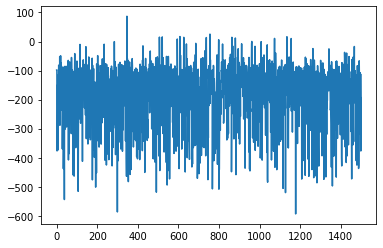

In [48]:
plt.plot(rew_per_episode)